The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3


Average Loss: 0.5013184988498688


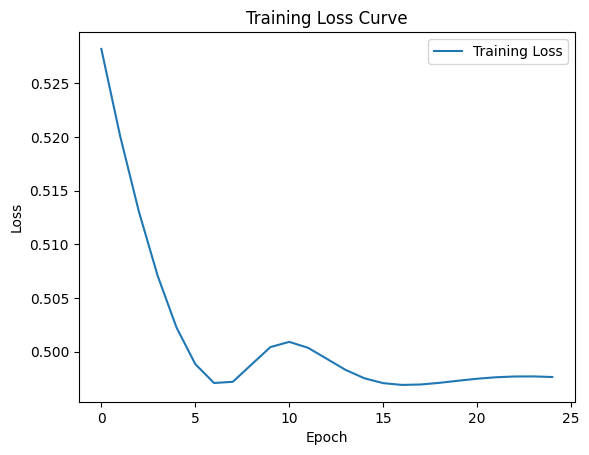

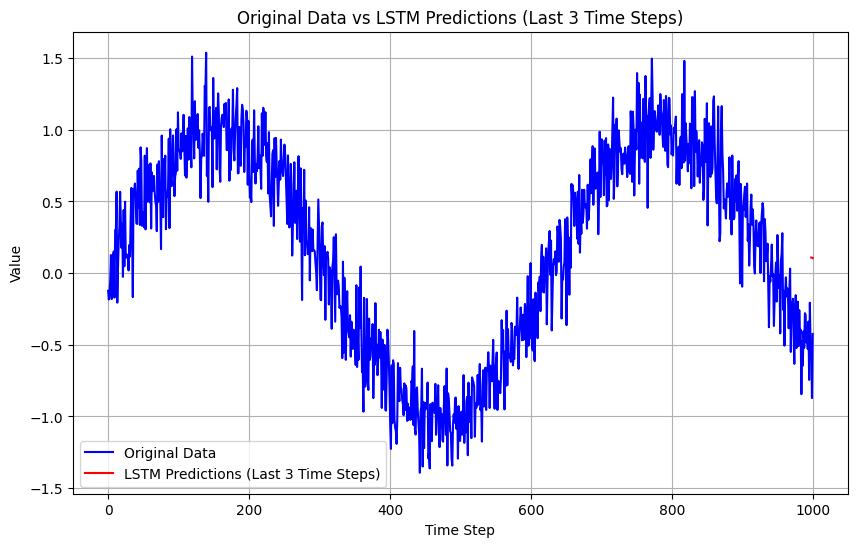

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h0=None):
        out, _ = self.lstm(x, h0)
        out = self.fc(out[:, -1, :])  # Use only the last time step for prediction
        return out

class LSTMTrainer:
    def __init__(self, input_size, hidden_size, output_size, lr=0.01, max_epochs=20):
        self.model = LSTM(input_size, hidden_size, output_size)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.max_epochs = max_epochs

    def train(self, data):
        losses = []
        for epoch in range(1, self.max_epochs + 1):
            epoch_loss = 0.0
            self.optimizer.zero_grad()
            # Unsqueeze to add batch dimension
            outputs = self.model(data[:-1].unsqueeze(0).unsqueeze(-1))
            loss = self.criterion(outputs, data[1:].unsqueeze(-1))
            loss.backward()
            self.optimizer.step()
            epoch_loss += loss.item()
            # Moved average epoch loss calculation outside the loop
            losses.append(epoch_loss)

        avg_epoch_loss = sum(losses) / len(losses)  # Calculate average loss per epoch
        print(f"Average Loss: {avg_epoch_loss}")
        # Plot training loss curve
        plt.plot(losses, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss Curve')
        plt.legend()
        plt.show()

    def predict(self, data):
        with torch.no_grad():
            predictions = []
            input_seq = data[-3:].unsqueeze(0).unsqueeze(-1)
            self.model.eval()  # Ensure the model is in evaluation mode
            hidden = None
            for i in range(3):  # We only predict the last 3 time steps
                output = self.model(input_seq, hidden)
                predictions.append(output.item())
                # Update input sequence with the predicted value
                input_seq = torch.cat((input_seq[:, 1:, :], output.unsqueeze(2)), dim=1)
        return predictions

# Example usage with LSTM
max_epochs = 25
lstm_trainer = LSTMTrainer(input_size=1, hidden_size=64, output_size=1, lr=0.001, max_epochs=max_epochs)
data = torch.sin(0.01 * torch.arange(1, 1001, dtype=torch.float32)) + torch.randn(1000) * 0.2
lstm_trainer.train(data)

# Perform one-step prediction
predictions = lstm_trainer.predict(data)

# Plot original data and predictions
plt.figure(figsize=(10, 6))
plt.plot(data, label='Original Data', color='blue')
plt.plot(range(len(data) - 3, len(data)), predictions, label='LSTM Predictions (Last 3 Time Steps)', color='red')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Original Data vs LSTM Predictions (Last 3 Time Steps)')
plt.legend()
plt.grid(True)
plt.show()
